In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import math
from IPython.display import display
from scipy.stats import zscore
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras

Preprocessing

In [166]:
def get_file_names(file_path):
    with open(file_path, 'r') as file:
        file_names = file.read().splitlines()
    
    modified_names = []
    for name in file_names:
        name = name[:3] + 'ID' + name[3:]
        name = name[:12] + 'C' + name[13:]
        modified_names.append(name)
    
    df = pd.DataFrame(modified_names,columns= ['Center_seq0'])
    
    return df

In [167]:
file_path = 'seq0_Gallery.list'
Center_seq0_file_names = get_file_names(file_path)
Center_seq0_file_names

,Center_seq0
0,T0_ID000104_Center_seq0.csv
1,T0_ID002318_Center_seq0.csv
2,T0_ID002422_Center_seq0.csv
3,T0_ID002526_Center_seq0.csv
4,T0_ID002630_Center_seq0.csv
...,...
740,T0_ID469459_Center_seq0.csv
741,T0_ID469875_Center_seq0.csv
742,T0_ID469979_Center_seq0.csv
743,T0_ID470122_Center_seq0.csv


In [168]:
file_path = 'seq1_Probe.list'
Center_seq1_file_names = get_file_names(file_path)
Center_seq1_file_names

,Center_seq0
0,T0_ID000104_Center_seq1.csv
1,T0_ID002318_Center_seq1.csv
2,T0_ID002422_Center_seq1.csv
3,T0_ID002526_Center_seq1.csv
4,T0_ID002630_Center_seq1.csv
...,...
740,T0_ID469459_Center_seq1.csv
741,T0_ID469875_Center_seq1.csv
742,T0_ID469979_Center_seq1.csv
743,T0_ID470122_Center_seq1.csv


In [169]:
gender_ids =  pd.read_csv("GenderIDList.txt", delimiter="\t")
gender_ids

,Female,Male
0,5327,2422
1,9859,2838
2,14950,9131
3,17127,13739
4,17439,15953
...,...,...
315,358973,323536
316,362333,354753
317,363232,357450
318,364547,357554


In [170]:
sequences = ["Center_seq0","Center_seq1","SlopeDown","SlopeUp","Walk1","Walk2"]
gender_ids_Center_seq0 = gender_ids.applymap(lambda x : f"T0_ID{str(int(x)).zfill(6)}_{sequences[0]}.csv")
gender_ids_Center_seq0

C:\Users\hp\AppData\Local\Temp\ipykernel_7856\2080540488.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gender_ids_Center_seq0 = gender_ids.applymap(lambda x : f"T0_ID{str(int(x)).zfill(6)}_{sequences[0]}.csv")


,Female,Male
0,T0_ID005327_Center_seq0.csv,T0_ID002422_Center_seq0.csv
1,T0_ID009859_Center_seq0.csv,T0_ID002838_Center_seq0.csv
2,T0_ID014950_Center_seq0.csv,T0_ID009131_Center_seq0.csv
3,T0_ID017127_Center_seq0.csv,T0_ID013739_Center_seq0.csv
4,T0_ID017439_Center_seq0.csv,T0_ID015953_Center_seq0.csv
...,...,...
315,T0_ID358973_Center_seq0.csv,T0_ID323536_Center_seq0.csv
316,T0_ID362333_Center_seq0.csv,T0_ID354753_Center_seq0.csv
317,T0_ID363232_Center_seq0.csv,T0_ID357450_Center_seq0.csv
318,T0_ID364547_Center_seq0.csv,T0_ID357554_Center_seq0.csv


In [171]:
gender_ids_Center_seq1 = gender_ids.applymap(lambda x : f"T0_ID{str(int(x)).zfill(6)}_{sequences[1]}.csv")
gender_ids_Center_seq1

C:\Users\hp\AppData\Local\Temp\ipykernel_7856\2693546531.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gender_ids_Center_seq1 = gender_ids.applymap(lambda x : f"T0_ID{str(int(x)).zfill(6)}_{sequences[1]}.csv")


,Female,Male
0,T0_ID005327_Center_seq1.csv,T0_ID002422_Center_seq1.csv
1,T0_ID009859_Center_seq1.csv,T0_ID002838_Center_seq1.csv
2,T0_ID014950_Center_seq1.csv,T0_ID009131_Center_seq1.csv
3,T0_ID017127_Center_seq1.csv,T0_ID013739_Center_seq1.csv
4,T0_ID017439_Center_seq1.csv,T0_ID015953_Center_seq1.csv
...,...,...
315,T0_ID358973_Center_seq1.csv,T0_ID323536_Center_seq1.csv
316,T0_ID362333_Center_seq1.csv,T0_ID354753_Center_seq1.csv
317,T0_ID363232_Center_seq1.csv,T0_ID357450_Center_seq1.csv
318,T0_ID364547_Center_seq1.csv,T0_ID357554_Center_seq1.csv


In [172]:
def get_data(required_files,headcount,target_files):
    
    valid_files = list(set(required_files) & set(target_files))
    
    combined_df = pd.DataFrame()
    count = 0
    
    for file_name in valid_files:
        if count >= headcount:
            break
        
        file_path = f"{file_name}"
        df = pd.read_csv(file_path,skiprows=2,header=None)
        df.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']    
        df['G_magnitude'] = np.sqrt(df['Gx']**2 + df['Gy']**2 + df['Gz']**2)
        df['A_magnitude'] = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
        combined_df =  pd.concat([combined_df, df],ignore_index= True)
        count += 1
    
    combined_df.columns =  ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az','G_mag','A_mag']   
    combined_df['Time'] = np.arange(0, len(combined_df) / 100, 0.01)
     
    
    return combined_df

In [173]:
headcount = 300
male_gait_data_Center_seq0 = get_data(gender_ids_Center_seq0['Male'],headcount,Center_seq0_file_names['Center_seq0'])
male_gait_data_Center_seq0

,Gx,Gy,Gz,Ax,Ay,Az,G_mag,A_mag,Time
0,-0.147733,-0.292092,0.067014,-0.014,-0.618,-0.066,0.334116,0.621672,0.00
1,-0.190344,-0.254808,0.051035,0.020,-0.626,-0.060,0.322122,0.629187,0.01
2,-0.185018,-0.180240,0.040382,0.054,-0.638,-0.096,0.261436,0.647438,0.02
3,-0.137081,-0.079039,0.045709,0.064,-0.668,-0.106,0.164705,0.679379,0.03
4,-0.158386,-0.009797,0.013751,0.058,-0.698,-0.110,0.159283,0.708991,0.04
...,...,...,...,...,...,...,...,...,...
176866,-0.360786,-0.158934,-0.002228,-0.122,-1.052,0.292,0.394248,1.098568,1768.66
176867,-0.456660,-0.158934,0.056361,-0.178,-0.980,0.268,0.486801,1.031459,1768.67
176868,-0.493944,-0.217524,0.082993,-0.186,-0.926,0.238,0.546063,0.974021,1768.68
176869,-0.461986,-0.302745,0.205498,-0.182,-0.912,0.180,0.589334,0.947242,1768.69


In [174]:
female_gait_data_Center_seq0 = get_data(gender_ids_Center_seq0['Female'],headcount,Center_seq0_file_names['Center_seq0'])
female_gait_data_Center_seq0

,Gx,Gy,Gz,Ax,Ay,Az,G_mag,A_mag,Time
0,0.059044,-0.045677,0.119915,0.290,-0.602,0.184,0.141252,0.693080,0.00
1,-0.004872,0.092807,0.221115,0.280,-0.594,0.168,0.239851,0.677835,0.01
2,-0.026177,0.220639,0.242420,0.270,-0.586,0.160,0.328838,0.664753,0.02
3,-0.122051,0.300534,0.295683,0.252,-0.598,0.146,0.438914,0.665150,0.03
4,-0.138030,0.391081,0.269052,0.224,-0.652,0.122,0.494354,0.700117,0.04
...,...,...,...,...,...,...,...,...,...
180147,-0.397482,-1.005910,-1.028640,-0.330,-1.208,0.452,1.492631,1.331341,1801.47
180148,-0.402802,-0.851454,-0.741020,-0.098,-0.872,0.282,1.198472,0.921690,1801.48
180149,0.044605,-0.665034,-0.554599,0.356,-1.222,0.156,0.867087,1.282324,1801.49
180150,0.454732,-0.318822,-0.543946,0.586,-1.386,0.298,0.777371,1.534013,1801.50


In [175]:
def find_avg_rows_per_peak(df):
    columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    
    total_peaks = 0
    total_rows = 0
    
    for col in columns:
        peaks, _ = find_peaks(df[col])
        
        total_peaks += len(peaks)
        if len(peaks) > 1:
            distances = np.diff(peaks)  
            total_rows += sum(distances)
    
    avg_rows_per_peak = total_rows / total_peaks if total_peaks > 0 else 0
    
    return avg_rows_per_peak

In [176]:
sequencing_length_male = find_avg_rows_per_peak(male_gait_data_Center_seq0)
sequencing_length_male

8.314769975786925

In [177]:
sequencing_length_female = find_avg_rows_per_peak(female_gait_data_Center_seq0)
sequencing_length_female

8.735272486280723

In [178]:
avg_sequencing_length = (sequencing_length_male + sequencing_length_female)/2
avg_sequencing_length

8.525021231033824

In [179]:
def divide_into_sequences(df, n, label):
    
    data = df.iloc[:, :8].values
    
    num_sequences = data.shape[0] // n
    
    sequences = data[:num_sequences * n].reshape(num_sequences, n, 8)

    labels = np.full(num_sequences, label)
    
    return sequences, labels

In [180]:
male_sequences,male_labels = divide_into_sequences(male_gait_data_Center_seq0,85,0)
female_sequences,female_labels = divide_into_sequences(female_gait_data_Center_seq0,85,1)

In [181]:
male_sequences

array([[[-0.147733  , -0.292092  ,  0.067014  , ..., -0.066     ,
          0.33411623,  0.62167194],
        [-0.190344  , -0.254808  ,  0.051035  , ..., -0.06      ,
          0.32212191,  0.62918678],
        [-0.185018  , -0.18024   ,  0.040382  , ..., -0.096     ,
          0.26143608,  0.64743803],
        ...,
        [-0.376765  ,  0.277824  , -0.114081  , ..., -0.266     ,
          0.48182208,  1.73696172],
        [-0.509923  ,  0.155319  , -0.257892  , ..., -0.306     ,
          0.59216023,  1.5982603 ],
        [-0.142407  ,  0.03814   , -0.438987  , ..., -0.226     ,
          0.46308099,  1.53204961]],

       [[ 0.395551  , -0.073713  , -0.641387  , ..., -0.036     ,
          0.75714694,  1.64830701],
        [ 0.36892   , -0.265461  , -0.763897  , ...,  0.17      ,
          0.8888814 ,  1.69059753],
        [-0.003923  , -0.638303  , -0.913027  , ...,  0.202     ,
          1.11403071,  1.39744195],
        ...,
        [ 0.091951  ,  0.837088  , -0.018207  , ..., -

In [182]:
male_labels

array([0, 0, 0, ..., 0, 0, 0])

In [183]:
female_sequences

array([[[ 5.90440000e-02, -4.56770000e-02,  1.19915000e-01, ...,
          1.84000000e-01,  1.41252219e-01,  6.93080082e-01],
        [-4.87200000e-03,  9.28070000e-02,  2.21115000e-01, ...,
          1.68000000e-01,  2.39851452e-01,  6.77834788e-01],
        [-2.61770000e-02,  2.20639000e-01,  2.42420000e-01, ...,
          1.60000000e-01,  3.28837741e-01,  6.64752586e-01],
        ...,
        [ 4.31886000e-01, -9.08543000e-01,  1.19915000e-01, ...,
          2.38000000e-01,  1.01309205e+00,  1.29589814e+00],
        [ 4.15907000e-01, -6.84836000e-01, -1.25096000e-01, ...,
          1.92000000e-01,  8.10942654e-01,  1.15594464e+00],
        [ 3.94602000e-01, -3.91888000e-01, -3.16843000e-01, ...,
          1.82000000e-01,  6.40059708e-01,  1.03132148e+00]],

       [[ 3.57318000e-01, -1.04266000e-01, -4.39349000e-01, ...,
          1.72000000e-01,  5.75825577e-01,  9.16113530e-01],
        [ 3.51992000e-01,  1.35418000e-01, -4.28696000e-01, ...,
          1.38000000e-01,  5.70978689e

In [184]:
female_labels

array([1, 1, 1, ..., 1, 1, 1])

In [185]:
final_sequences = np.concatenate((male_sequences,female_sequences),axis=0)
final_labels = np.concatenate((male_labels,female_labels))

In [186]:
print("Shape of Final Sequence Data :",final_sequences.shape)
final_sequences

Shape of Final Sequence Data : (4199, 85, 8)


array([[[-1.47733000e-01, -2.92092000e-01,  6.70140000e-02, ...,
         -6.60000000e-02,  3.34116225e-01,  6.21671939e-01],
        [-1.90344000e-01, -2.54808000e-01,  5.10350000e-02, ...,
         -6.00000000e-02,  3.22121912e-01,  6.29186777e-01],
        [-1.85018000e-01, -1.80240000e-01,  4.03820000e-02, ...,
         -9.60000000e-02,  2.61436080e-01,  6.47438028e-01],
        ...,
        [-3.76765000e-01,  2.77824000e-01, -1.14081000e-01, ...,
         -2.66000000e-01,  4.81822078e-01,  1.73696172e+00],
        [-5.09923000e-01,  1.55319000e-01, -2.57892000e-01, ...,
         -3.06000000e-01,  5.92160233e-01,  1.59826030e+00],
        [-1.42407000e-01,  3.81400000e-02, -4.38987000e-01, ...,
         -2.26000000e-01,  4.63080986e-01,  1.53204961e+00]],

       [[ 3.95551000e-01, -7.37130000e-02, -6.41387000e-01, ...,
         -3.60000000e-02,  7.57146937e-01,  1.64830701e+00],
        [ 3.68920000e-01, -2.65461000e-01, -7.63897000e-01, ...,
          1.70000000e-01,  8.88881396e

In [187]:
class_labels = pd.Series(["Male","Female"])
class_labels
no_classes = len(class_labels)

In [188]:
print("Shape of labels :", final_labels.shape )
final_labels

Shape of labels : (4199,)


array([0, 0, 0, ..., 1, 1, 1])

In [189]:
frequency = np.bincount(final_labels)
frequency

array([2080, 2119], dtype=int64)

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

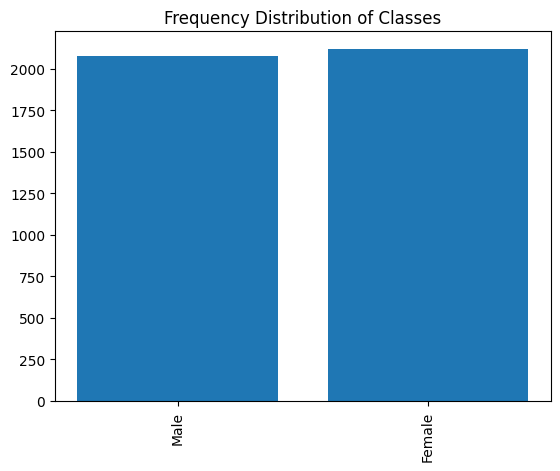

In [190]:
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Classes")
plt.xticks(rotation=90)

In [191]:
all_labels = np.copy(final_labels)
all_labels

array([0, 0, 0, ..., 1, 1, 1])

In [192]:
final_labels = to_categorical(final_labels,no_classes)
print("Shape of labels: ",final_labels.shape)
final_labels

Shape of labels:  (4199, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [193]:
final_sequences = zscore(final_sequences,axis=1)
final_sequences

array([[[-1.94798146e-01, -1.03565723e+00,  2.76152195e-01, ...,
          7.44578350e-01, -7.69468882e-01, -1.60209603e+00],
        [-3.93396599e-01, -9.38859826e-01,  1.97030126e-01, ...,
          7.74497587e-01, -8.35375379e-01, -1.57412175e+00],
        [-3.68573540e-01, -7.45265013e-01,  1.44280429e-01, ...,
          5.94982164e-01, -1.16883263e+00, -1.50618074e+00],
        ...,
        [-1.26225492e+00,  4.43969166e-01, -6.20562936e-01, ...,
         -2.52729557e-01,  4.21470444e-02,  2.54961452e+00],
        [-1.88286868e+00,  1.25919432e-01, -1.33266156e+00, ...,
         -4.52191138e-01,  6.48434488e-01,  2.03329300e+00],
        [-1.69975088e-01, -1.78302842e-01, -2.22937669e+00, ...,
         -5.32679753e-02, -6.08317378e-02,  1.78682105e+00]],

       [[ 1.66212715e+00,  6.52660787e-02, -1.70893702e+00, ...,
          1.47159503e-01,  8.57703929e-01,  1.96697979e+00],
        [ 1.54607839e+00, -4.15976080e-01, -2.06623541e+00, ...,
          1.09519589e+00,  1.30989943e

In [194]:
sequence_shape = final_sequences.shape[1:]
print(sequence_shape)

(85, 8)


LSTM Model

In [195]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [196]:
X = final_sequences
y = final_labels

In [197]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [198]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=sequence_shape)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [199]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.5243 - loss: 0.6923 - val_accuracy: 0.5762 - val_loss: 0.6718
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.5889 - loss: 0.6597 - val_accuracy: 0.6349 - val_loss: 0.6486
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.6794 - loss: 0.6120 - val_accuracy: 0.6508 - val_loss: 0.6340
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7109 - loss: 0.5777 - val_accuracy: 0.7286 - val_loss: 0.5569
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7290 - loss: 0.5528 - val_accuracy: 0.7190 - val_loss: 0.5616
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7622 - loss: 0.5150 - val_accuracy: 0.6952 - val_loss: 0.5709
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7808 - loss: 0.5008 - val_accuracy: 0.7095 - val_loss: 0.5821
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7748 - loss: 0.4737 - val_accuracy: 0

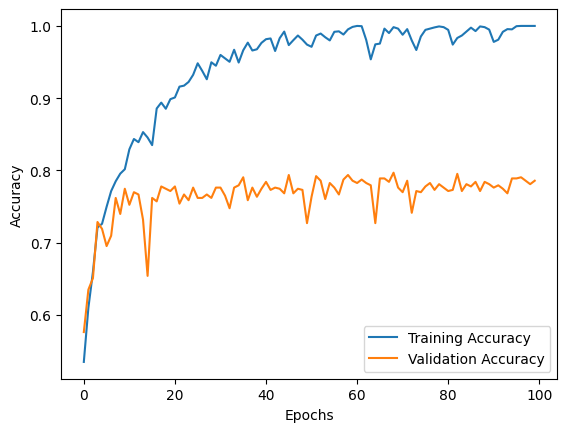

In [200]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()